In [32]:
import numpy as np
from typing import Callable
from matplotlib import pyplot as plt
from os import listdir
import optuna
from tqdm.notebook import tqdm

In [33]:
dir_name = '/Users/alv.popov/study/ml/data/lab4/messages'

def read_file(filename) -> tuple[set, int]:
    with open(filename) as f:
        content = set(map(int, f.readline().split()[1:]))
        f.readline()
        content.update(map(int, f.readline().split()))
        is_spam = int('spmsg' in filename)
        return content, is_spam

def read_part(dirname: str) -> tuple[np.ndarray, np.ndarray]:
    x, y = [], []
    for filename in listdir(dirname):
        content, is_spam = read_file(f"{dirname}/{filename}")
        x.append(content)
        y.append(is_spam)
    return np.array(x), np.array(y)

def read_data(dirname: str) -> np.ndarray:
    data = []
    for part_dir in listdir(dirname):
        data.append(read_part(f"{dirname}/{part_dir}"))
    return np.array(data)

def train_test_xy_split_data(data: np.ndarray, i: int) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    train, test = np.concatenate([data[:i], data[i + 1:]]), data[i]
    return np.concatenate(train[:, 0]), np.concatenate(train[:, 1]), test[0], test[1]

data = read_data(dir_name)

In [34]:
class Bayes:
    def __init__(self, n: int = None, alpha: float = 0, l=None):
        if n is None and l is None:
            raise Exception

        if n is None:
            n = len(l)

        if l is None:
            l = np.ones(n)

        self.n = n
        self.alpha = alpha
        self.l = l
        self.p_y = None
        self.p_wy = None

    def fit(self, x_train: np.ndarray, y_train: np.ndarray):
        p_y = dict()
        p_wy = dict()
        all_words = set()

        for w in x_train:
            all_words.update(w)

        for y in range(self.n):
            p_y[y] = 0
            p_wy[y] = dict()
            for word in all_words:
                p_wy[y][word] = 0

        for y, words in zip(y_train, x_train):
            p_y[y] += 1
            for w in words:
                p_wy[y][w] += 1

        for y in p_wy.keys():
            for w in p_wy[y].keys():
                p_wy[y][w] = (p_wy[y][w] + self.alpha) / (p_y[y] + 2 * self.alpha)
            p_y[y] /= n

        self.p_y = p_y
        self.p_wy = p_wy
        return self

    def get_probabilities(self, x: set) -> np.ndarray:
        import math
        p_pred = []

        def safe_log(val: float) -> float:
            if val == 0:
                return -math.inf
            else:
                return math.log(val)

        for y in range(self.n):
            p = safe_log(self.l[y] * self.p_y[y])
            for w in self.p_wy[y]:
                if w in x:
                    p += safe_log(self.p_wy[y][w])
                else:
                    p += safe_log(1 - self.p_wy[y][w])
            p_pred.append(p)

        p_pred_max = max(p_pred)
        p_pred = list(map(lambda p: math.exp(p - p_pred_max), p_pred))
        sum_p_pred = sum(p_pred)
        p_pred = list(map(lambda p: p / sum_p_pred, p_pred))

        return np.array(p_pred)

    def predict1(self, x: set) -> int:
        return int(np.argmax(self.get_probabilities(x)))

    def predict(self, x: np.ndarray) -> np.ndarray:
        return np.vectorize(self.predict1)(x)

In [35]:
# проверим для n = 1..3
log = []
for n in tqdm(range(1, 4)):
    for alpha in tqdm(np.linspace(0, 0.1, 10)):
        x = np.concatenate(data[:, 0])
        model = Bayes(n, alpha).fit(x, np.random.randint(0, n, len(x)))
        probs = model.get_probabilities(x[0])
        log.append(f"n={n} alpha={alpha} probs={probs}")

log

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

['n=1 alpha=0.0 probs=[1.]',
 'n=1 alpha=0.011111111111111112 probs=[1.]',
 'n=1 alpha=0.022222222222222223 probs=[1.]',
 'n=1 alpha=0.03333333333333333 probs=[1.]',
 'n=1 alpha=0.044444444444444446 probs=[1.]',
 'n=1 alpha=0.05555555555555556 probs=[1.]',
 'n=1 alpha=0.06666666666666667 probs=[1.]',
 'n=1 alpha=0.07777777777777778 probs=[1.]',
 'n=1 alpha=0.08888888888888889 probs=[1.]',
 'n=1 alpha=0.1 probs=[1.]',
 'n=2 alpha=0.0 probs=[1. 0.]',
 'n=2 alpha=0.011111111111111112 probs=[9.99999887e-01 1.12651367e-07]',
 'n=2 alpha=0.022222222222222223 probs=[4.53974796e-11 1.00000000e+00]',
 'n=2 alpha=0.03333333333333333 probs=[0.92075416 0.07924584]',
 'n=2 alpha=0.044444444444444446 probs=[1.00000000e+00 7.83249308e-54]',
 'n=2 alpha=0.05555555555555556 probs=[0.95041488 0.04958512]',
 'n=2 alpha=0.06666666666666667 probs=[5.73366424e-07 9.99999427e-01]',
 'n=2 alpha=0.07777777777777778 probs=[9.99999992e-01 7.83853420e-09]',
 'n=2 alpha=0.08888888888888889 probs=[9.99999948e-01 5.

In [36]:
def accuracy(y_pred: np.ndarray, y_test: np.ndarray) -> float:
    return np.count_nonzero(y_pred == y_test) / len(y_pred)

def cross_validate(
        model_supplier: Callable[[], Bayes],
        loss_f: Callable[[np.ndarray, np.ndarray], float] = accuracy,
        k: int = 10,
) -> float:
    acc = 0
    for i in range(k):
        x_train, y_train, x_test, y_test = train_test_xy_split_data(data, i)
        y_pred = model_supplier().fit(x_train, y_train).predict(x_test)
        acc += loss_f(y_pred, y_test)
    return acc / k

In [37]:
study = optuna.create_study(direction="maximize")

def objective(trial: optuna.Trial) -> float:
    alpha = trial.suggest_uniform("alpha", 0, 1)
    l1 = trial.suggest_uniform("l1", 0, 1)
    l2 = trial.suggest_uniform("l2", 0, 1)

    model_supplier = lambda: Bayes(alpha=alpha, l=[l1, l2])
    return cross_validate(model_supplier)

study.optimize(objective, n_trials=20, show_progress_bar=True)
best_params = study.best_params
best_params

[I 2022-06-01 02:34:44,601] A new study created in memory with name: no-name-35fb2c1a-a794-469f-a652-3cb65c44b819
/Users/alv.popov/study/ml/venv/lib/python3.9/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-06-01 02:35:09,214] Trial 0 finished with value: 0.9449541284403669 and parameters: {'alpha': 0.2690254401538307, 'l1': 0.42975621493568983, 'l2': 0.296732087065649}. Best is trial 0 with value: 0.9449541284403669.
[I 2022-06-01 02:35:30,857] Trial 1 finished with value: 0.9449541284403669 and parameters: {'alpha': 0.26706640633198886, 'l1': 0.7604508045261854, 'l2': 0.17110892861585691}. Best is trial 0 with value: 0.9449541284403669.
[I 2022-06-01 02:35:53,366] Trial 2 finished with value: 0.9394495412844037 and parameters: {'alpha': 0.3694006871068829, 'l1': 0.635481394321911, 'l2': 0.08572633694488252}. Best is trial 0 with value: 0.9449541284403669.
[I 2022-06-01 02:36:17,014] Trial 3 finished with value: 0.9201834862385322 and parameters: {'alpha': 0.9753270139182548, 'l1': 0.39193243735957994, 'l2': 0.8228037501679868}. Best is trial 0 with value: 0.9449541284403669.
[I 2022-06-01 02:36:37,356] Trial 4 finished with value: 0.9275229357798166 and parameters: {'alpha': 0.9

{'alpha': 0.005484748237229669,
 'l1': 0.9851270483248334,
 'l2': 0.2000703105431597}

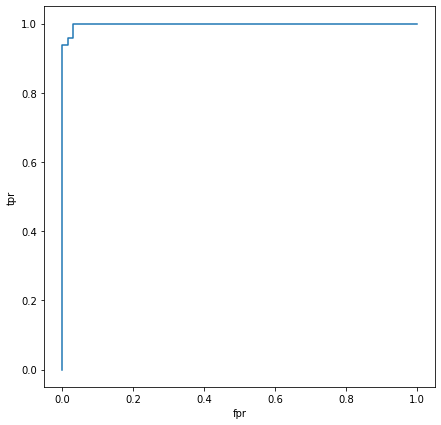

In [54]:
from sklearn.metrics import roc_curve

model = Bayes(alpha=best_params["alpha"], l=[best_params["l1"], best_params["l2"]])
x_train, y_train, x_test, y_test = train_test_xy_split_data(data, 0)
trained_model = model.fit(x_train, y_train)
y_pred = np.array(list(map(trained_model.get_probabilities, x_test)))[:, 1]

fpr, tpr, _ = roc_curve(y_test.astype('int64'), y_pred)

plt.figure(figsize=(7, 7))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot(fpr, tpr)

### Подберем l_legit при фиксированном l_spam

In [55]:
def all_true_are_positive(y_pred: np.ndarray, y_test: np.ndarray) -> float:
    tp, t = 0, 0
    for y1, y2 in zip(y_pred, y_test):
        if y2 == 1:
            t += 1
        if y1 == y2 == 1:
            tp += 1
    return tp / t if t > 0 else 1

loss1 = []
loss2 = []
l_legit = best_params["l1"]

while True:
    model_supplier = lambda: Bayes(alpha=best_params["alpha"], l=[best_params["l1"], l_legit])
    a1 = cross_validate(model_supplier, all_true_are_positive)
    a2 = cross_validate(model_supplier)
    loss1.append(a1)
    loss2.append(a2)
    print(a1)
    if a1 == 1:
        break
    l_legit *= 10

print(l_legit)

0.9229166666666668
0.9291666666666668
0.9416666666666667
0.9520833333333332
0.9520833333333332
0.9645833333333332
0.9729166666666667
0.975
0.98125
0.9833333333333334
0.9854166666666666
0.9875
0.9875
0.9895833333333334
0.9916666666666668
0.99375
0.99375
0.99375
0.99375
0.99375
0.9958333333333332
0.9979166666666666
0.9979166666666666
0.9979166666666666
0.9979166666666666
0.9979166666666666
1.0
9.851270483248337e+25


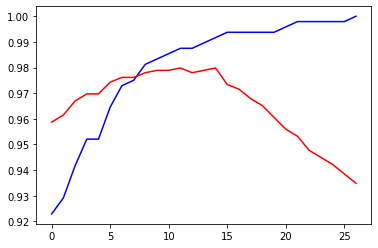

In [56]:
# l = 0.2 .. 0.2 * 10**25 , step = *10
plt.plot(loss1, color='blue')
plt.plot(loss2, color='red')